<h1> Kaggle Project </h1>
<h2> Porto Seguro’s Safe Driver Prediction </h2><br>
by John Sullivan, Paul Schuetze <br><br><br><br>

# The Problem

In this notebook we work on a problem given by Porto Seguro Insurance Company. We are predicting the probability "that a driver will initiate an auto insurance claim in the next year." For this we are using the given data and we are training a machine learning algorithm on it. The algorithm will give us a probability of a driver filing an insurance claim in the next year.

<b> The Goal </b><br>
For each instance we try to give back a probability value of an insurance claim. In other words, we try to predict the probability of a customer initiating an insurance claim in the next year.

<b> The Plan </b><br>
<b>1) </b> Explore, prepare and clean the data <br>
<b>2) </b> Try simple Machine Learning -> get a rough idea about accuracies <br>
<b>3) </b> Explore dimensionality reduction <br>
<b>4) </b> Combine different approaches (dimensionailty reductions + machine learning)<br>
<b>5) </b> Chose our model <br>
<b>6) </b> Optimization of our algorithm

<b> Issues/ Challenges </b><br>
- The data is not possible to interpret, we need to work with it as is. This does not leave us any room for ideas of changing the data according to its meaning.
- It is difficult to work with the Gini Coefficient. For the normal accuracy scores we are getting pretty high results, around 95% accuracy. This completely changes when using the Gini Coefficient though. 


<b> What we have learned </b><br>
The problem seems to be rather difficult, because we are trying to maximize classifier accuracy even though it is already very high. Also the data cleaning process and the exploration was rather lenghty. Not much context is given, which makes plotting and dimensionality reduction challenging. <br>
We also learned that a proper approach to this kind of problem takes a long time. Getting really good results seems to require lots of hard work. Additionally, we realized that real life problems have much larger datasets and are not easy to be processed by our computers. Splitting the data into smaller parts is crucial.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preparing and Exploring Data

Getting Data and replacing the -1 values by NaN. 

In [2]:
# Read data
dat = pd.read_csv('train.csv')
# Put nan
dat = dat.replace(-1, np.nan)

<h2> General Information about the Data </h2>

In [4]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     594996 non-null float64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595129 non-null float64
ps_ind_05_cat     589403 non-null float64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64

In [5]:
print(dat.shape[0], 'Instances in the data')
print(dat.shape[1], 'Features in the data')

595212 Instances in the data
59 Features in the data


<h2> Missing Data </h2><br>
Find out with how much missing data we are dealing:

In [6]:
# Get missing data counts per column
nan_counts = ((dat.isnull().sum() / len(dat.id)) * 100).astype(int)
nan_counts = nan_counts[nan_counts > 0]
nan = pd.DataFrame(nan_counts)
nan = nan.rename(columns = {0:'percentage'})
pd.DataFrame(nan)

percentage
ps_reg_03              18
ps_car_03_cat          69
ps_car_05_cat          44
ps_car_07_cat           1
ps_car_14               7

<b> Results </b><br> Especially columns 'ps_car_05_cat' and 'ps_car_03_cat' have a very high amount of missing data (both are close to 50% missing values). We thus decided that we will not impute missing values in these features, but we are dropping the whole feature. We think it would not make much sense imputing almost 50% of a feature's data as it will throw off our model.

Drop two features (<b>'ps_car_05_cat'</b> and <b>'ps_car_03_cat'</b>) from the data:

In [7]:
nan_counts = nan_counts[nan_counts > 30]
dat = dat.drop(list(nan_counts.keys()), axis=1)

<h2> Feature Exploration </h2>

In [8]:
## Get feature names
features = list(dat.keys())
features.pop(0)
features.pop(0)

## Sort feature types
types = []
cat_features = []
bin_features = []
real_features = []

# Organize by bin, cat, real
for name in features:
    tp = name[-3:]
    
    if tp == 'cat':
        #types.append((tp, name))
        cat_features.append(name)
    elif tp == 'bin':
        #types.append((tp, name))
        bin_features.append(name)
    else:
        #types.append(('real',name))
        real_features.append(name)
        
types = [cat_features,bin_features,real_features]


<b> Feature Overview </b>

In [9]:
print(len(cat_features), 'Categorical Features')
print(len(bin_features), 'Binary Features')
print(len(real_features), 'Real Value Features')

12 Categorical Features
17 Binary Features
26 Real Value Features


<b> Seperate categorical and numerical features</b><br> Here we seperate all three different feature types from each other. We find out how many categorical features we still need to encode. We are adding the categorical features which only have two values to the binary features.

In [10]:
# Separate catgorical-numeric frames
numeric = dat[real_features]
categorical = dat[cat_features]

# Pick out categorical features with only two values
not_categorical = []

for name,series in categorical.iteritems():
    unq = series.unique()
    unq = unq[~np.isnan(unq)]
    if len(unq) == 2:
        not_categorical.append(name)
        
binary = dat[bin_features + not_categorical]
categorical = categorical.drop(not_categorical, axis=1)

<b> Results </b><br> We are left with:

In [11]:
print(len(categorical.columns), 'Categorical features to encode')

8 Categorical features to encode


<b> Feature Correlations </b><br>
Here we are exploring the correlation of the features to our target value. 

In [12]:
# Correlation test
dat_noid = dat.drop(['id'], axis=1)
corr_matrix = dat_noid.corr()
pd.DataFrame(corr_matrix['target'].sort_values(ascending = False).head())

target
target         1.000000
ps_car_13      0.053899
ps_car_12      0.038800
ps_ind_17_bin  0.037053
ps_reg_02      0.034800

<b> Results </b><br> 
We can see that the single features are not even weakly correlated to our target value. The correlation coefficient is very small for all features. We thus cannot focus on any particular features from just analyzing them. However, we will be able to use different types of dimensionality reduction later.

<h2> Data Visualization </h2><br>
Here we try to visualize some aspects of the data.

<b> Target Plot </b>

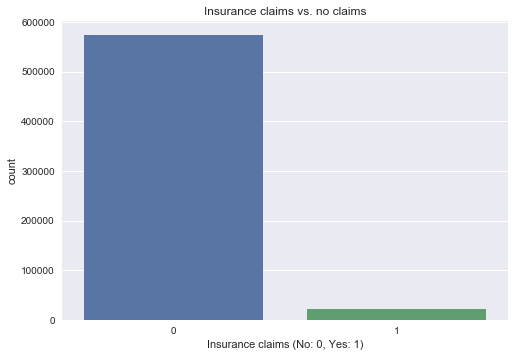

In [13]:
# Barplot target (claim-no claim)
plot = sns.countplot(x="target", data=dat)
plt.title('Insurance claims vs. no claims')
plt.xlabel('Insurance claims (No: 0, Yes: 1)')
plt.show()

<b> Distribution of numerical feature values </b>

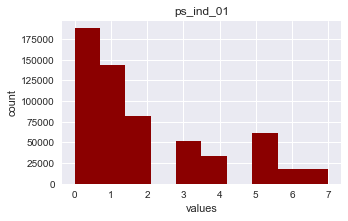

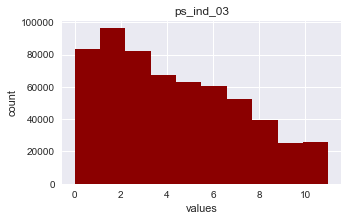

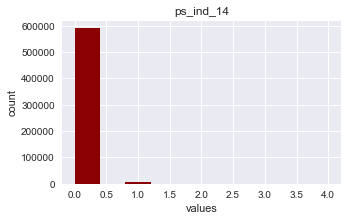

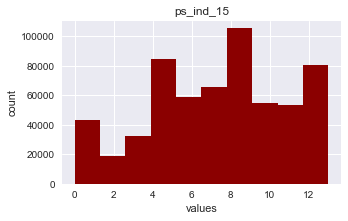

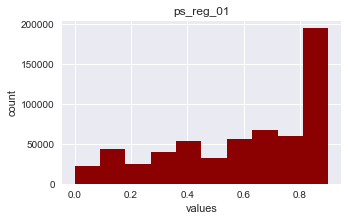

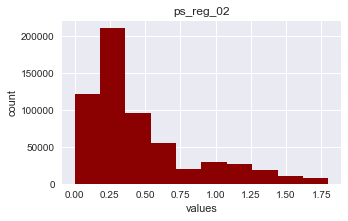

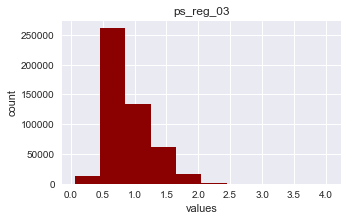

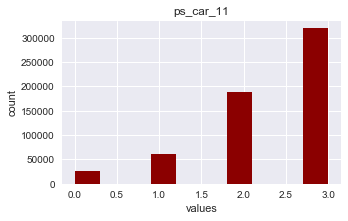

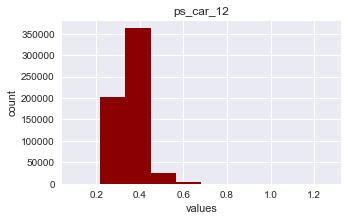

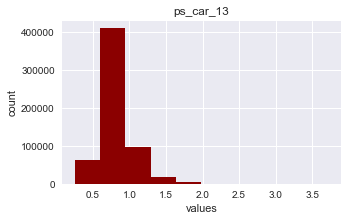

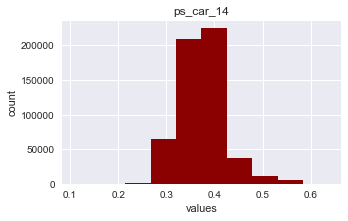

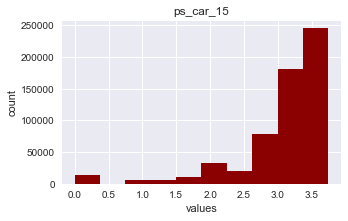

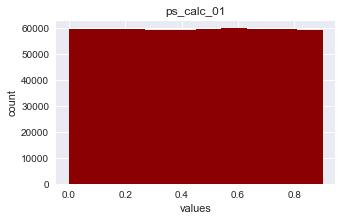

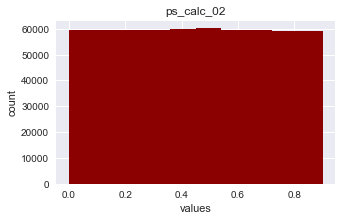

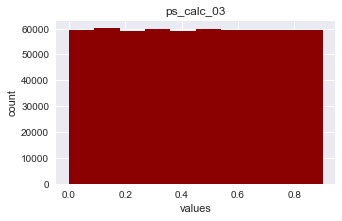

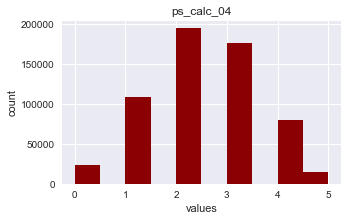

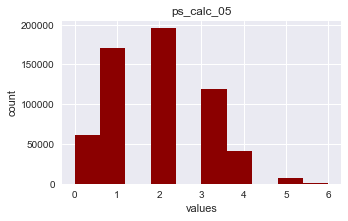

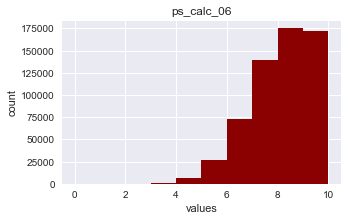

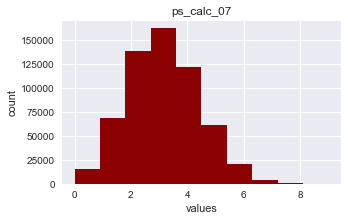

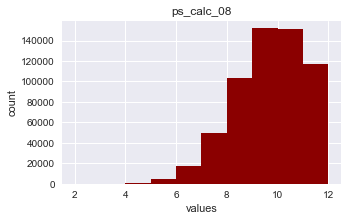

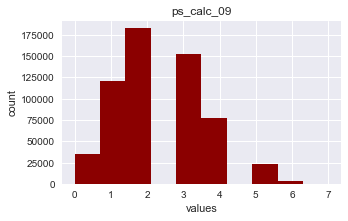

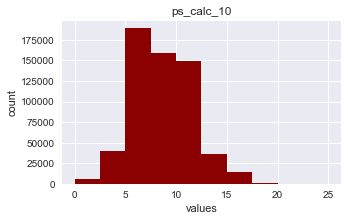

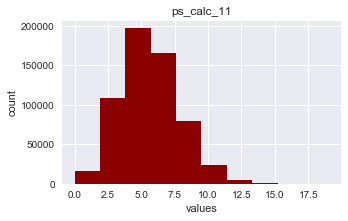

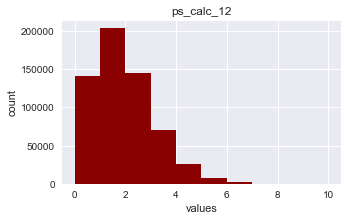

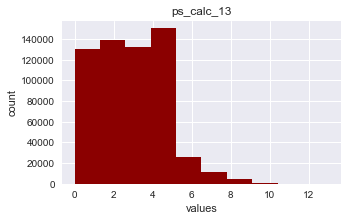

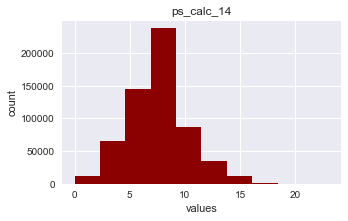

In [45]:
for column in numeric.columns:
    plt.figure(figsize=(5,3))
    numeric[column].hist(  color='darkred')
    plt.title(column)
    plt.ylabel('count')
    plt.xlabel('values')
    plt.show()

<b> Distribution of categorical feature values </b>

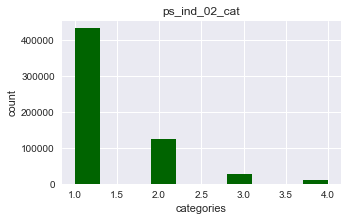

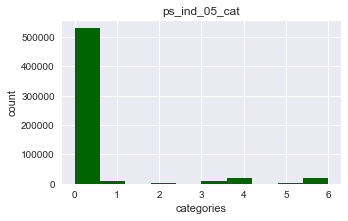

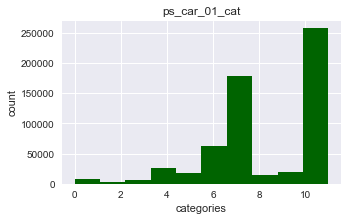

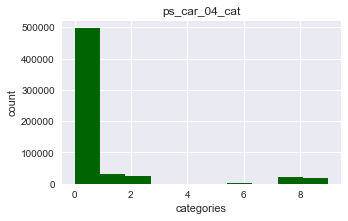

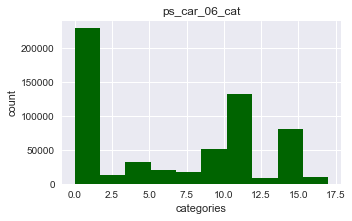

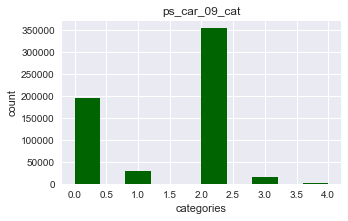

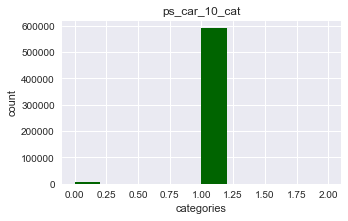

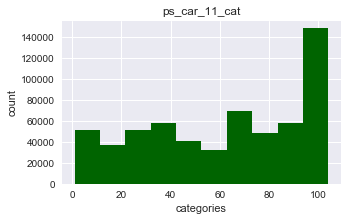

In [46]:
for column in categorical.columns:
    plt.figure(figsize=(5,3))
    categorical[column].hist(  color='darkgreen')
    plt.title(column)
    plt.ylabel('count')
    plt.xlabel('categories')
    plt.show()

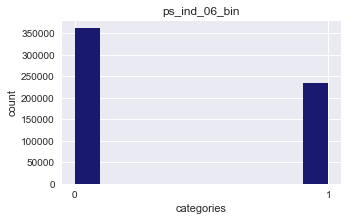

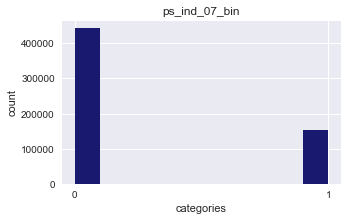

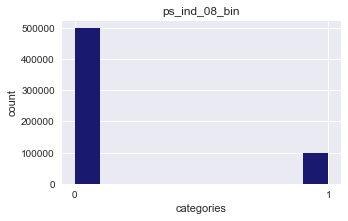

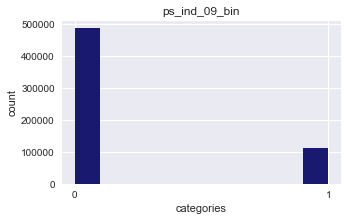

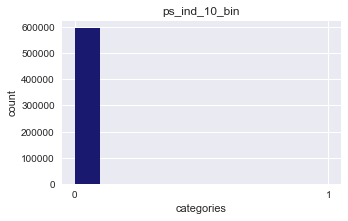

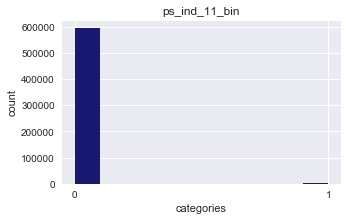

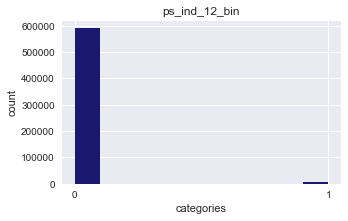

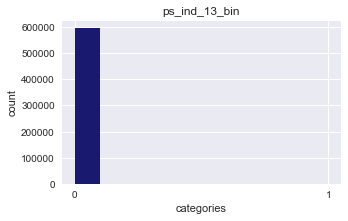

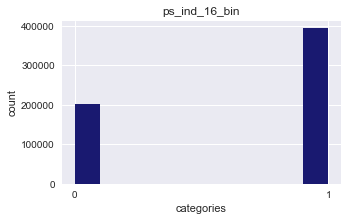

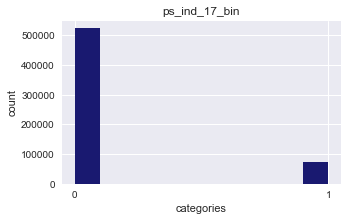

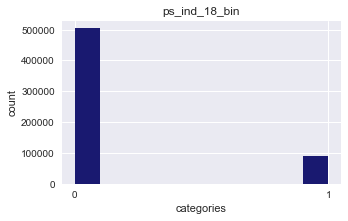

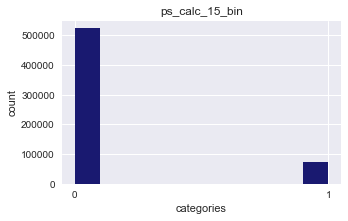

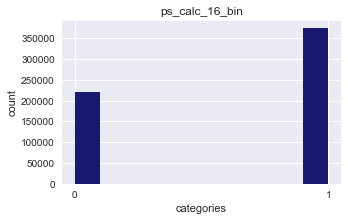

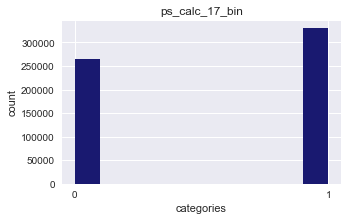

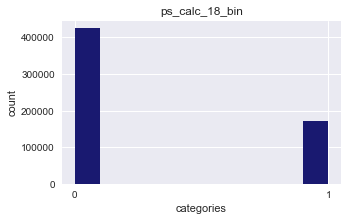

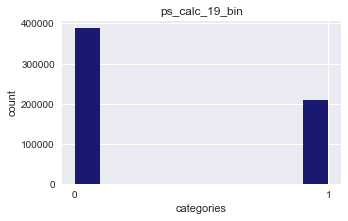

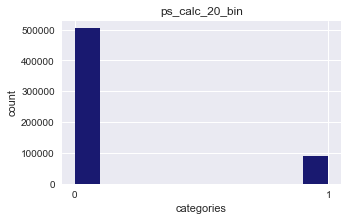

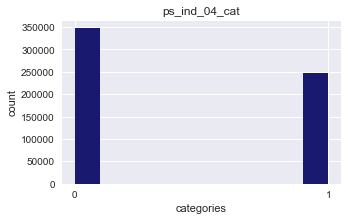

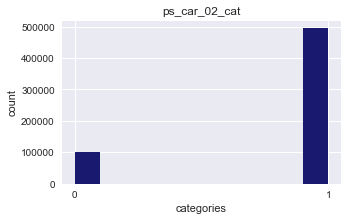

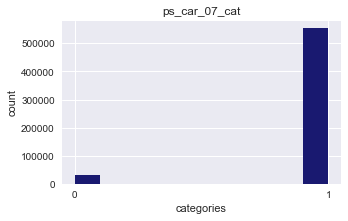

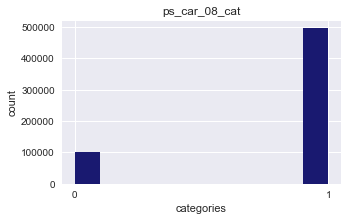

In [47]:
for column in binary.columns:
    plt.figure(figsize=(5,3))
    binary[column].hist(  color='midnightblue')
    plt.title(column)
    plt.xticks([0, 1])
    plt.ylabel('count')
    plt.xlabel('categories')
    plt.show()


<h2> Data Cleaning </h2><br>
Here we are cleaning the data. We are getting rid of NaN values and we are already encoding categorical feature values.

In [48]:
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.preprocessing import Imputer,StandardScaler,LabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin

We use pipelines to process data. After this the data is ready for testing on a machine learning algorithm.

In [49]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
class Multipipe(BaseEstimator, TransformerMixin):
    def __init__(self, operation):
        self.operation = operation
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return np.column_stack([self.operation.fit_transform(column) for column in X.T])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_features)),
        ('imputer', Imputer(strategy='most_frequent')),
        ('label_binarizer', Multipipe(LabelBinarizer())),
    ])
    
bin_pipeline = Pipeline([
        ('selector', DataFrameSelector(bin_features)),
        ('imputer', Imputer(strategy='most_frequent')),
    ])
    
real_pipeline = Pipeline([
        ('selector', DataFrameSelector(real_features)),
        ('imputer', Imputer(strategy='median')),
    ])
    
union = FeatureUnion([
        ('pipe_real', real_pipeline),
        ('pipe_bin', bin_pipeline),
        ('pipe_cat', cat_pipeline),
    ])
    
piped = union.fit_transform(dat)


<h2> Machine learning tests </h2>

Here we explore a couple simple algorithms to get a rough idea about the accuracy scores. This way we know what to expect and what to aim for.

In [51]:
# Machine learning
from sklearn.model_selection import train_test_split as trsplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

<b> Gini Coefficient </b><br>We try to use the Gini Coefficient to analyze our resutls as well. This is because it turns out that even though our accuracy scores are generally pretty high, the gini coefficient score is completely different.

In [53]:
### From: https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703#5897 ###

def gini(actual, pred, cmpcol = 0, sortcol = 1):
     assert( actual.shape[0] == pred.shape[0] )
     all = np.asarray(np.c_[ actual, pred, np.arange(actual.shape[0]) ], dtype=np.float)
     all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
     totalLosses = all[:,0].sum()
     giniSum = all[:,0].cumsum().sum() / totalLosses
 
     giniSum -= (len(actual) + 1) / 2.
     return giniSum / actual.shape[0]
 
def gini_normalized(a, p):
     return gini(a, p) / gini(a, a)
    
######

<b> First Tests </b> <br>
We use three different classifiers to test on a sample of our data. We used LogisticRegression, RandomForest and a DecisionTree. The results can be seen below.

In [57]:

X_train,X_test,y_train,y_test = trsplit(piped, dat.target.values)
X_train_prime,X_test_prime,y_train_prime,y_test_prime = trsplit(X_train,y_train)


estimators = [
        { 'name' : 'logisitic_regression', 'obj' : LogisticRegression(), 'predicted' : None, 'acc' : 0.0, 'gini' : 0.0 },
        { 'name' : 'random_forest', 'obj' : RandomForestClassifier(), 'predicted' : None, 'acc' : 0.0, 'gini' : 0.0 },
        { 'name' : 'decision_tree', 'obj' : DecisionTreeClassifier(), 'predicted' : None, 'acc' : 0.0, 'gini' : 0.0 },
    ]

for est in estimators:
    classifier = est['obj']
    classifier.fit(X_train_prime, y_train_prime)
    est['acc'] = classifier.score(X_test_prime, y_test_prime)
    est['predicted'] = classifier.predict_proba(X_test_prime)[:,1]
    est['gini'] = gini_normalized(y_test_prime, est['predicted'])
    print(est['name'],':\n', 'Accuracy Score:', est['acc'], ', Gini Coefficient:', est['gini'])


logisitic_regression :
 Accuracy Score: 0.963316398305 , Gini Coefficient: 0.241829630532
random_forest :
 Accuracy Score: 0.963325358637 , Gini Coefficient: 0.0772888565565
decision_tree :
 Accuracy Score: 0.921516446691 , Gini Coefficient: 0.0154100912277


<h2> Preliminary results </h2><br>
We cleaned the data, had a look at the different features and looked at some distributional plots. For now we cannot conclude too much. It is alsow very difficult to interpret the data. However, if we further do some dimensionality reduction we might be able to say more. <br>
We also ran a first couple classifiers on our data. So far we can say that logistic regression works the best in terms of the Gini Coefficient.

<b> Plan for the next week </b> <br>
We need to makes use of different dimensionality reduction methods and try to combine certain approaches. We are looking into using a blender, in connection to dimensionality reduction. We thought it might be interesting to try to reduce the dimnesionality of the training set for the blender (so reduce dimensionality of the predictions of the base estimators). This still has to be seen, as we only did tests fot that on the MNIST data yet. <br>
We also need to chose and fine tune our model. The longest part here will probably be the running time of the algorithms.